In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install torch torchvision pandas scikit-learn tqdm matplotlib seaborn --quiet

import zipfile
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.0 MB/s eta 0:00:00


This cell mounts Google Drive and installs all required Python packages for the pipeline including PyTorch, Pandas, TorchVision, and others. It also imports essential libraries for model training, evaluation, and data processing.

In [2]:
DATASET_PATH = "/content/drive/MyDrive/SafeRoad/References & Links for Datasets"
ARCHIVE_PATH = f"{DATASET_PATH}/archive.zip"
TEST_IMAGES_PATH = f"{DATASET_PATH}/my_test_images"
MODEL_SAVE_PATH = "/content/drive/MyDrive/SafeRoad/Code/Saved Models"

# Create model save directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(f"Dataset path: {DATASET_PATH}")
print(f"Archive path: {ARCHIVE_PATH}")
print(f"Test images path: {TEST_IMAGES_PATH}")
print(f"Model save path: {MODEL_SAVE_PATH}")

Dataset path: /content/drive/MyDrive/SafeRoad/References & Links for Datasets
Archive path: /content/drive/MyDrive/SafeRoad/References & Links for Datasets/archive.zip
Test images path: /content/drive/MyDrive/SafeRoad/References & Links for Datasets/my_test_images
Model save path: /content/drive/MyDrive/SafeRoad/Code/Saved Models


Defines all the paths needed in the project:

DATASET_PATH: Where the dataset zip file is stored in Drive

ARCHIVE_PATH: The zip file to be extracted

TEST_IMAGES_PATH: Folder containing custom test images

MODEL_SAVE_PATH: Folder where trained models will be saved

In [3]:
extract_path = '/content/FL3D'
if not os.path.exists(extract_path):
    print("Extracting FL3D dataset from archive.zip...")
    if os.path.exists(ARCHIVE_PATH):
        with zipfile.ZipFile(ARCHIVE_PATH, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete!")
    else:
        print(f"ERROR: Archive not found at {ARCHIVE_PATH}")
        print("Please check the file path!")
else:
    print("Dataset already extracted!")

FL3D_ROOT = '/content/FL3D/classification_frames'

Extracting FL3D dataset from archive.zip...
Extraction complete!


Extracts the archive.zip containing the FL3D dataset into /content/FL3D if not already extracted. This avoids repeated unzipping in subsequent runs.

In [4]:
print("\nProcessing annotations...")
ann_path = os.path.join(FL3D_ROOT, 'annotations_train.json')

if os.path.exists(ann_path):
    with open(ann_path, 'r') as f:
        annotations = json.load(f)

    # Create DataFrame with binary labels
    records = []
    for rel_path, data in annotations.items():
        driver_state = data['driver_state']
        if driver_state not in ['alert', 'microsleep', 'yawning']:
            continue

        label = 0 if driver_state == 'alert' else 1
        rel_path_fixed = rel_path[2:] if rel_path.startswith('./') else rel_path
        img_path = os.path.join('/content/FL3D', rel_path_fixed)

        records.append({
            'img': os.path.basename(rel_path_fixed),
            'label': label,
            'img_path': img_path,
            'driver_state': driver_state
        })

    df_fl3d = pd.DataFrame(records)
    print(f"Full dataset size: {len(df_fl3d)}")
else:
    print(f"ERROR: Annotations file not found at {ann_path}")
    print("Please check if the archive.zip was extracted correctly!")


Processing annotations...
Full dataset size: 48327


Loads annotations_train.json, filters for valid classes (alert, microsleep, yawning), and converts labels into binary format:

0 → Alert

1 → Drowsy (Microsleep or Yawning)
Creates a DataFrame df_fl3d with image paths and labels.

In [5]:
SAMPLES_PER_CLASS = 3000  # Increased for better accuracy
df_small = pd.concat([
    df_fl3d[df_fl3d['label']==0].sample(min(SAMPLES_PER_CLASS, len(df_fl3d[df_fl3d['label']==0])), random_state=42),
    df_fl3d[df_fl3d['label']==1].sample(min(SAMPLES_PER_CLASS, len(df_fl3d[df_fl3d['label']==1])), random_state=42)
]).reset_index(drop=True)

print(f"\nUsing dataset size: {len(df_small)}")
print("Class distribution:")
print(df_small['label'].value_counts())

# Train/Val split
train_df, val_df = train_test_split(
    df_small,
    test_size=0.2,
    stratify=df_small['label'],
    random_state=42
)

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Using dataset size: 6000
Class distribution:
label
0    3000
1    3000
Name: count, dtype: int64

Training samples: 4800
Validation samples: 1200


Selects a balanced subset of 3000 samples per class (or fewer if limited), then performs an 80/20 stratified train-validation split. Ensures equal class representation and avoids overfitting on small classes.

In [6]:
class FL3DDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "img_path"]
        label = self.df.loc[idx, "label"]

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            return self.__getitem__((idx + 1) % len(self.df))

        if self.transform:
            image = self.transform(image)

        return image, label

Defines a custom PyTorch Dataset class to load images and labels from the DataFrame. Automatically skips and retries loading if any image is unreadable.

In [7]:
IMG_SIZE = 224

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

Creates two sets of transformations:

Training: Heavy augmentations to improve generalization.

Validation: Standard resizing and normalization for evaluation.

In [8]:
BATCH_SIZE = 32 if torch.cuda.is_available() else 16
NUM_WORKERS = 4 if torch.cuda.is_available() else 2

train_dataset = FL3DDataset(train_df, transform_train)
val_dataset = FL3DDataset(val_df, transform_val)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Builds DataLoader objects for training and validation using the datasets and transformations. Batch size and worker count are set based on whether GPU is available.

In [9]:
def create_optimized_model(model_type='resnet50'):
    """Create an optimized model with proper fine-tuning setup"""
    if model_type == 'resnet50':
        model = models.resnet50(pretrained=True)
        # Freeze early layers
        for name, param in model.named_parameters():
            if 'layer4' not in name and 'layer3' not in name and 'fc' not in name:
                param.requires_grad = False
        # Replace classifier
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    return model

# Initialize model
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {DEVICE}")

model = create_optimized_model('resnet50')
model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


Total parameters: 24,558,146
Trainable parameters: 23,113,218


Initializes a pre-trained ResNet50 model with:

Frozen early layers

A new classifier head for binary classification
Moves model to GPU if available and displays total and trainable parameter counts.

In [10]:
y_train = train_df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
print(f"Class weights: {class_weights}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Different learning rates for pretrained and new layers
pretrained_params = []
new_params = []
for name, param in model.named_parameters():
    if param.requires_grad:
        if 'fc' in name:
            new_params.append(param)
        else:
            pretrained_params.append(param)

optimizer = optim.Adam([
    {'params': pretrained_params, 'lr': 1e-4},
    {'params': new_params, 'lr': 5e-4}
])

# Learning rate schedulers
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)

# Mixed precision training
scaler = GradScaler() if torch.cuda.is_available() else None

Class weights: tensor([1., 1.], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipython-input-10-1282425794.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if torch.cuda.is_available() else None


Calculates class weights to handle imbalance, and sets up:

Cross-entropy loss with weights

Optimizer (Adam) with different learning rates for old vs. new layers

Learning rate schedulers and mixed-precision training (AMP)

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        if scaler and torch.cuda.is_available():
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': loss.item(), 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    class_correct = [0, 0]
    class_total = [0, 0]

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Per-class accuracy
            for i in range(labels.size(0)):
                label = labels[i].item()
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

            pbar.set_postfix({'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100. * correct / total

    # Print per-class accuracy
    print(f"\nAlert accuracy: {100.*class_correct[0]/class_total[0]:.2f}%")
    print(f"Drowsy accuracy: {100.*class_correct[1]/class_total[1]:.2f}%")

    return epoch_loss, epoch_acc

Defines reusable functions:

train_epoch: Runs one epoch of training

validate: Evaluates model on validation set
Also tracks and prints per-class accuracy during validation.

In [12]:
EPOCHS = 30
patience = 7
best_val_acc = 0.0
epochs_no_improve = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

print("\nStarting optimized training...")
for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"{'='*50}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE, scaler)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate scheduling
    if epoch < 5:
        warmup_scheduler.step()
    else:
        scheduler.step(val_acc)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_acc': train_acc,
        }

        # Save to both temporary and permanent locations
        temp_model_path = 'fl3d_best_model_optimized.pth'
        torch.save(checkpoint, temp_model_path)

        # Save to your Code/Saved Models folder
        permanent_model_path = os.path.join(MODEL_SAVE_PATH, 'fl3d_best_model_optimized.pth')
        torch.save(checkpoint, permanent_model_path)

        print(f"✓ Best model saved to: {permanent_model_path}")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")


Starting optimized training...

Epoch 1/30


Training:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-11-1172678943.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 38/38 [00:05<00:00,  6.51it/s, acc=95.33%]



Alert accuracy: 94.17%
Drowsy accuracy: 96.50%

Train Loss: 0.3797 | Train Acc: 82.35%
Val Loss: 0.1273 | Val Acc: 95.33%
Learning Rate: 0.000028
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 2/30


Validation: 100%|██████████| 38/38 [00:05<00:00,  6.47it/s, acc=97.25%]



Alert accuracy: 96.17%
Drowsy accuracy: 98.33%

Train Loss: 0.1180 | Train Acc: 95.69%
Val Loss: 0.0845 | Val Acc: 97.25%
Learning Rate: 0.000046
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 3/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.93it/s, acc=97.67%]



Alert accuracy: 98.17%
Drowsy accuracy: 97.17%

Train Loss: 0.0881 | Train Acc: 96.94%
Val Loss: 0.0571 | Val Acc: 97.67%
Learning Rate: 0.000064
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 4/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.64it/s, acc=98.08%]



Alert accuracy: 97.67%
Drowsy accuracy: 98.50%

Train Loss: 0.0801 | Train Acc: 97.29%
Val Loss: 0.0591 | Val Acc: 98.08%
Learning Rate: 0.000082
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 5/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  7.84it/s, acc=97.92%]



Alert accuracy: 98.83%
Drowsy accuracy: 97.00%

Train Loss: 0.0701 | Train Acc: 97.54%
Val Loss: 0.0665 | Val Acc: 97.92%
Learning Rate: 0.000100
No improvement for 1 epoch(s)

Epoch 6/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.70it/s, acc=98.25%]



Alert accuracy: 97.83%
Drowsy accuracy: 98.67%

Train Loss: 0.0584 | Train Acc: 98.00%
Val Loss: 0.0561 | Val Acc: 98.25%
Learning Rate: 0.000100
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 7/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.74it/s, acc=98.25%]



Alert accuracy: 98.33%
Drowsy accuracy: 98.17%

Train Loss: 0.0536 | Train Acc: 98.08%
Val Loss: 0.0496 | Val Acc: 98.25%
Learning Rate: 0.000100
No improvement for 1 epoch(s)

Epoch 8/30


Validation: 100%|██████████| 38/38 [00:05<00:00,  7.00it/s, acc=98.50%]



Alert accuracy: 97.67%
Drowsy accuracy: 99.33%

Train Loss: 0.0519 | Train Acc: 98.17%
Val Loss: 0.0459 | Val Acc: 98.50%
Learning Rate: 0.000100
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 9/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.51it/s, acc=96.83%]



Alert accuracy: 96.50%
Drowsy accuracy: 97.17%

Train Loss: 0.0476 | Train Acc: 98.58%
Val Loss: 0.0958 | Val Acc: 96.83%
Learning Rate: 0.000100
No improvement for 1 epoch(s)

Epoch 10/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.29it/s, acc=98.67%]



Alert accuracy: 98.67%
Drowsy accuracy: 98.67%

Train Loss: 0.0496 | Train Acc: 98.33%
Val Loss: 0.0443 | Val Acc: 98.67%
Learning Rate: 0.000100
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 11/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  7.89it/s, acc=98.42%]



Alert accuracy: 97.33%
Drowsy accuracy: 99.50%

Train Loss: 0.0416 | Train Acc: 98.42%
Val Loss: 0.0562 | Val Acc: 98.42%
Learning Rate: 0.000100
No improvement for 1 epoch(s)

Epoch 12/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.99it/s, acc=98.17%]



Alert accuracy: 97.67%
Drowsy accuracy: 98.67%

Train Loss: 0.0401 | Train Acc: 98.71%
Val Loss: 0.0519 | Val Acc: 98.17%
Learning Rate: 0.000100
No improvement for 2 epoch(s)

Epoch 13/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.44it/s, acc=98.42%]



Alert accuracy: 98.83%
Drowsy accuracy: 98.00%

Train Loss: 0.0393 | Train Acc: 98.60%
Val Loss: 0.0529 | Val Acc: 98.42%
Learning Rate: 0.000100
No improvement for 3 epoch(s)

Epoch 14/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.71it/s, acc=98.25%]



Alert accuracy: 97.50%
Drowsy accuracy: 99.00%

Train Loss: 0.0348 | Train Acc: 98.77%
Val Loss: 0.0411 | Val Acc: 98.25%
Learning Rate: 0.000050
No improvement for 4 epoch(s)

Epoch 15/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.30it/s, acc=98.75%]



Alert accuracy: 98.00%
Drowsy accuracy: 99.50%

Train Loss: 0.0254 | Train Acc: 99.12%
Val Loss: 0.0476 | Val Acc: 98.75%
Learning Rate: 0.000050
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 16/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.45it/s, acc=98.92%]



Alert accuracy: 98.50%
Drowsy accuracy: 99.33%

Train Loss: 0.0202 | Train Acc: 99.35%
Val Loss: 0.0415 | Val Acc: 98.92%
Learning Rate: 0.000050
✓ Best model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth

Epoch 17/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.62it/s, acc=98.92%]



Alert accuracy: 98.67%
Drowsy accuracy: 99.17%

Train Loss: 0.0170 | Train Acc: 99.40%
Val Loss: 0.0395 | Val Acc: 98.92%
Learning Rate: 0.000050
No improvement for 1 epoch(s)

Epoch 18/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.25it/s, acc=98.50%]



Alert accuracy: 98.83%
Drowsy accuracy: 98.17%

Train Loss: 0.0224 | Train Acc: 99.35%
Val Loss: 0.0479 | Val Acc: 98.50%
Learning Rate: 0.000050
No improvement for 2 epoch(s)

Epoch 19/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.95it/s, acc=98.58%]



Alert accuracy: 99.00%
Drowsy accuracy: 98.17%

Train Loss: 0.0231 | Train Acc: 99.23%
Val Loss: 0.0455 | Val Acc: 98.58%
Learning Rate: 0.000050
No improvement for 3 epoch(s)

Epoch 20/30


Validation: 100%|██████████| 38/38 [00:05<00:00,  7.23it/s, acc=98.67%]



Alert accuracy: 98.83%
Drowsy accuracy: 98.50%

Train Loss: 0.0171 | Train Acc: 99.42%
Val Loss: 0.0472 | Val Acc: 98.67%
Learning Rate: 0.000025
No improvement for 4 epoch(s)

Epoch 21/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.95it/s, acc=98.92%]



Alert accuracy: 98.83%
Drowsy accuracy: 99.00%

Train Loss: 0.0149 | Train Acc: 99.46%
Val Loss: 0.0475 | Val Acc: 98.92%
Learning Rate: 0.000025
No improvement for 5 epoch(s)

Epoch 22/30


Validation: 100%|██████████| 38/38 [00:05<00:00,  6.83it/s, acc=98.08%]



Alert accuracy: 98.83%
Drowsy accuracy: 97.33%

Train Loss: 0.0154 | Train Acc: 99.48%
Val Loss: 0.0577 | Val Acc: 98.08%
Learning Rate: 0.000025
No improvement for 6 epoch(s)

Epoch 23/30


Validation: 100%|██████████| 38/38 [00:04<00:00,  8.61it/s, acc=98.75%]


Alert accuracy: 98.67%
Drowsy accuracy: 98.83%

Train Loss: 0.0164 | Train Acc: 99.33%
Val Loss: 0.0419 | Val Acc: 98.75%
Learning Rate: 0.000025
No improvement for 7 epoch(s)

Early stopping triggered at epoch 23

Training completed! Best validation accuracy: 98.92%


Runs the main training loop:

Trains for up to 30 epochs (early stopping if no improvement for 7)

Tracks accuracy and loss

Saves the best model based on validation accuracy to both local and Google Drive

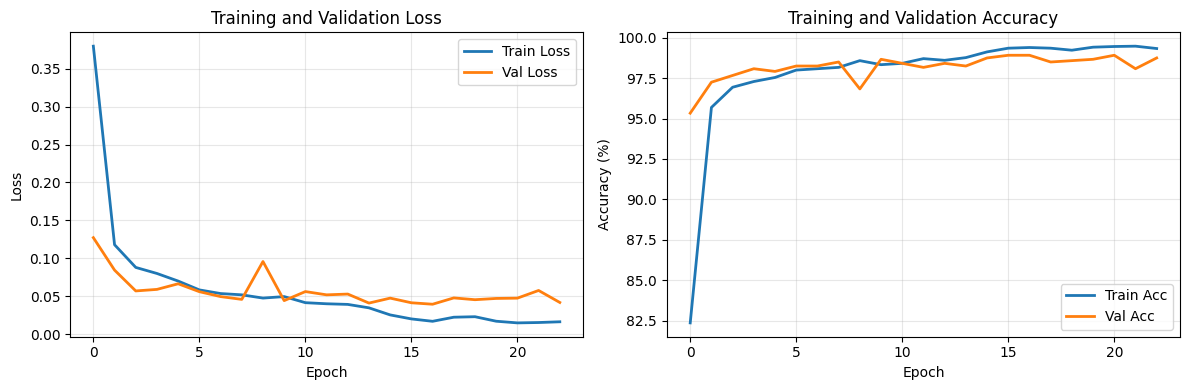

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Visualizes training and validation loss and accuracy over epochs in a dual-subplot figure. Helps diagnose underfitting or overfitting.

In [14]:
# Load the best model
checkpoint = torch.load('fl3d_best_model_optimized.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with val acc: {checkpoint['val_acc']:.2f}%")
model.eval()

# Your test images
test_images = [
    'IMG-20250712-WA0001.jpg',  # Eyes closed - Expected: Drowsy
    'IMG-20250712-WA0002.jpg',  # Yawning - Expected: Drowsy
    'IMG-20250712-WA0003.jpg',  # Alert - Expected: Alert
    'IMG-20250712-WA0004.jpg'   # Alert - Expected: Alert
]

# Check if test folder exists
if not os.path.exists(TEST_IMAGES_PATH):
    print(f"ERROR: Test folder not found: {TEST_IMAGES_PATH}")
    print("Creating a placeholder folder...")
    os.makedirs(TEST_IMAGES_PATH, exist_ok=True)
else:
    print(f"✓ Found test folder: {TEST_IMAGES_PATH}")
    test_files = os.listdir(TEST_IMAGES_PATH)
    print(f"✓ Files in folder: {test_files}")

# Test each image
results = []
label_names = {0: "Alert", 1: "Drowsy"}

for img_name in test_images:
    img_path = os.path.join(TEST_IMAGES_PATH, img_name)

    if os.path.exists(img_path):
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform_val(image).unsqueeze(0).to(DEVICE)

        # Get prediction
        with torch.no_grad():
            output = model(img_tensor)
            probs = torch.softmax(output, dim=1)
            pred_class = output.argmax(1).item()

            alert_score = probs[0, 0].item()
            drowsy_score = probs[0, 1].item()
            confidence = max(alert_score, drowsy_score) * 100

        prediction = label_names[pred_class]

        result = {
            'filename': img_name,
            'prediction': prediction,
            'confidence': confidence,
            'alert_prob': alert_score * 100,
            'drowsy_prob': drowsy_score * 100
        }
        results.append(result)

        print(f"\n{img_name}:")
        print(f"  Prediction: {prediction}")
        print(f"  Confidence: {confidence:.1f}%")
        print(f"  Alert probability: {alert_score*100:.1f}%")
        print(f"  Drowsy probability: {drowsy_score*100:.1f}%")
    else:
        print(f"\n{img_name}: FILE NOT FOUND!")
        results.append({
            'filename': img_name,
            'prediction': 'N/A',
            'confidence': 0,
            'alert_prob': 0,
            'drowsy_prob': 0
        })

Loaded model from epoch 16 with val acc: 98.92%
✓ Found test folder: /content/drive/MyDrive/SafeRoad/References & Links for Datasets/my_test_images
✓ Files in folder: ['IMG-20250712-WA0002.jpg', 'IMG-20250712-WA0001.jpg', 'IMG-20250712-WA0003.jpg', 'IMG-20250712-WA0004.jpg']

IMG-20250712-WA0001.jpg:
  Prediction: Drowsy
  Confidence: 99.0%
  Alert probability: 1.0%
  Drowsy probability: 99.0%

IMG-20250712-WA0002.jpg:
  Prediction: Drowsy
  Confidence: 100.0%
  Alert probability: 0.0%
  Drowsy probability: 100.0%

IMG-20250712-WA0003.jpg:
  Prediction: Alert
  Confidence: 99.9%
  Alert probability: 99.9%
  Drowsy probability: 0.1%

IMG-20250712-WA0004.jpg:
  Prediction: Alert
  Confidence: 100.0%
  Alert probability: 100.0%
  Drowsy probability: 0.0%


Loads the best saved model and evaluates it on custom test images (placed in your Drive under my_test_images). Displays prediction, confidence, and probabilities.

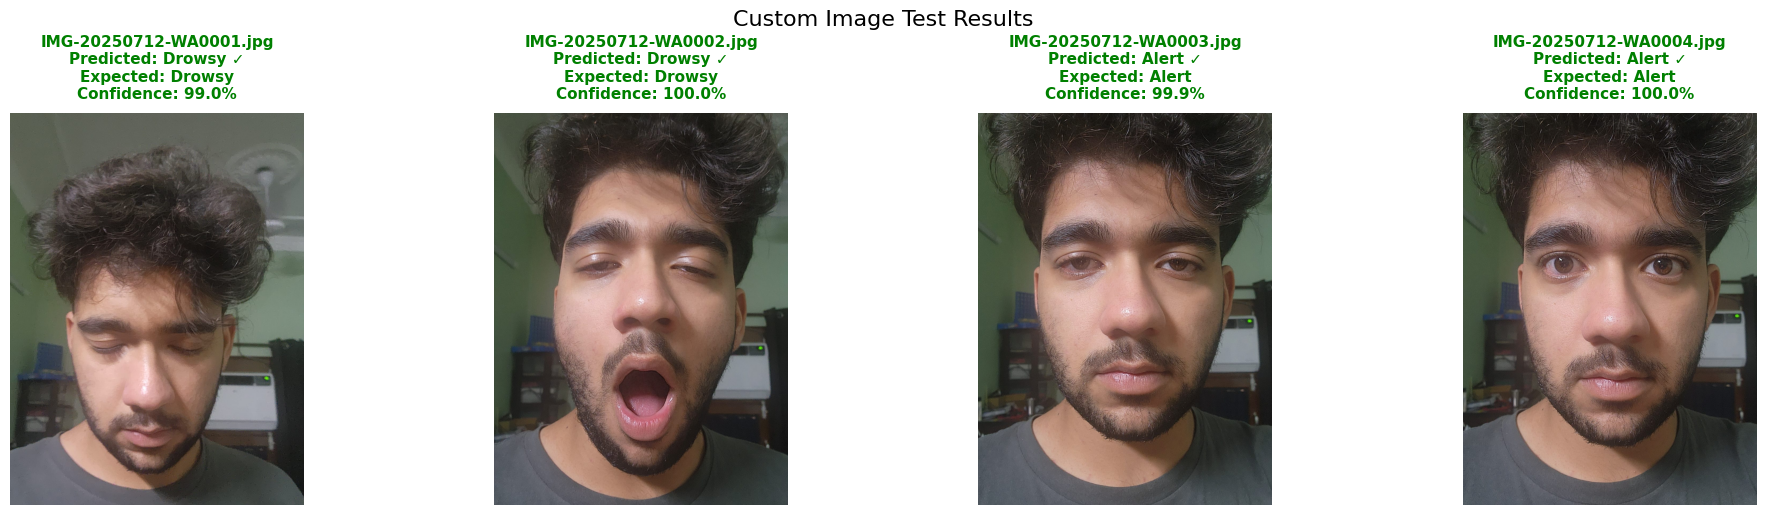

In [15]:
if any(os.path.exists(os.path.join(TEST_IMAGES_PATH, img)) for img in test_images):
    fig = plt.figure(figsize=(20, 5))

    expected = {
        'IMG-20250712-WA0001.jpg': 'Drowsy',
        'IMG-20250712-WA0002.jpg': 'Drowsy',
        'IMG-20250712-WA0003.jpg': 'Alert',
        'IMG-20250712-WA0004.jpg': 'Alert'
    }

    for idx, (img_name, result) in enumerate(zip(test_images, results)):
        img_path = os.path.join(TEST_IMAGES_PATH, img_name)

        if os.path.exists(img_path) and result['prediction'] != 'N/A':
            ax = plt.subplot(1, 4, idx + 1)

            # Load and display image
            image = Image.open(img_path).convert('RGB')
            ax.imshow(image)
            ax.axis('off')

            # Prepare title
            pred = result['prediction']
            conf = result['confidence']
            exp = expected[img_name]
            match_symbol = '✓' if pred == exp else '✗'

            title = f"{img_name}\n"
            title += f"Predicted: {pred} {match_symbol}\n"
            title += f"Expected: {exp}\n"
            title += f"Confidence: {conf:.1f}%"

            # Color based on correctness
            color = 'green' if pred == exp else 'red'
            ax.set_title(title, fontsize=11, color=color, weight='bold', pad=10)

            # Add colored border
            for spine in ax.spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(3)

    plt.tight_layout()
    plt.suptitle('Custom Image Test Results', fontsize=16, y=1.02)
    plt.show()

Displays each test image with:

Predicted label vs. Expected label

Confidence level

Colored title and border for correct/incorrect predictions
Creates a visual summary of model performance on unseen examples.

In [16]:
if results:
    results_df = pd.DataFrame(results)
    results_csv_path = os.path.join(MODEL_SAVE_PATH, 'test_results.csv')
    results_df.to_csv(results_csv_path, index=False)
    print(f"\n Test results saved to: {results_csv_path}")


 Test results saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/test_results.csv


Saves the test results (filename, prediction, confidence, class probabilities) to a CSV file in your Google Drive for future reference or reporting.

In [17]:
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Model saved to: {MODEL_SAVE_PATH}")
print(f"Test results saved to: {results_csv_path if results else 'N/A'}")

Best validation accuracy: 98.92%
Model saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models
Test results saved to: /content/drive/MyDrive/SafeRoad/Code/Saved Models/test_results.csv


Prints a summary at the end:

Best validation accuracy

Model save path

Path to saved test results
Indicates that training and testing have been successfully completed.

# Driver Drowsiness Detection – Project Summary

### Project Overview
This notebook implements a full training and inference pipeline to detect driver drowsiness using the FL3D dataset. A ResNet50 model, pre-trained on ImageNet, is fine-tuned for binary classification (Alert vs Drowsy), with enhanced augmentations and performance optimizations.

---

### 1. Dataset Source and Access
- The dataset (`archive.zip`) is stored in Google Drive under:
  `/MyDrive/SafeRoad/References & Links for Datasets`
- It is extracted into `/content/FL3D` if not already done.
- Annotations are loaded from `annotations_train.json` inside the extracted dataset.

---

### 2. Dataset Processing
- The dataset focuses only on 3 driver states: `alert`, `microsleep`, and `yawning`
- Labels are mapped as:
  - `alert` → 0 (Alert)
  - `microsleep` / `yawning` → 1 (Drowsy)
- The processed dataset is stored as a DataFrame with image paths and binary labels.

---

### 3. Sampling and Splitting
- Up to 3000 samples are taken per class to ensure class balance.
- The dataset is split into 80% training and 20% validation sets using stratified sampling.

---

### 4. Data Augmentation
- Training images are augmented using random crops, flips, color jitter, perspective warping, and erasing.
- Validation images are resized and center-cropped.
- All images are normalized and resized to 224×224.

---

### 5. Model Architecture
- A pre-trained ResNet50 model is used.
- Early layers are frozen; only `layer3`, `layer4`, and the final classifier are fine-tuned.
- The classifier is replaced with a custom head for binary classification:
  Dropout → Linear → ReLU → Dropout → Linear → 2 outputs

---

### 6. Training Configuration
- Loss function: CrossEntropyLoss with class weighting to handle imbalance
- Optimizer: Adam with different learning rates for pre-trained and new layers
- Scheduler: Warmup followed by ReduceLROnPlateau
- Mixed-precision training is enabled using AMP for performance on GPUs
- Early stopping is applied if no improvement in validation accuracy for 7 epochs

---

### 7. Model Evaluation and Saving
- After each epoch, model accuracy and loss are reported
- The best-performing model (based on validation accuracy) is saved to:
  `/MyDrive/SafeRoad/Code/Saved Models/fl3d_best_model_optimized.pth`
- Also saved locally during runtime as `fl3d_best_model_optimized.pth`

---

### 8. Training History Visualization
- Accuracy and loss trends across all epochs are plotted to evaluate overfitting or underfitting.

---

### 9. Custom Image Testing
- A list of 4 custom test images is evaluated from the folder:
  `/MyDrive/SafeRoad/References & Links for Datasets/my_test_images`
- Each image is passed through the trained model to obtain:
  - Predicted class (Alert or Drowsy)
  - Confidence score
  - Probability scores for both classes

---

### 10. Visual Result Display
- All tested images are displayed side-by-side with:
  - Predicted vs expected label
  - Confidence score
  - Colored borders for correct (green) or incorrect (red) predictions

---

### 11. Result Logging
- Results are saved as `test_results.csv` in:
  `/MyDrive/SafeRoad/Code/Saved Models`

---

### 12. Summary
- Best validation accuracy is reported at the end of training.
- All model artifacts and predictions are saved to Google Drive for persistence.
